# SENTIMENT ANALYSIS OF AIRLINE TWEETS

# Business Understanding

## Overview
In the highly competitive airline industry, leveraging sentiment analysis can provide a competitive edge. By analyzing various sources of customer feedback, such as social media posts, sentiment analysis can determine whether the sentiment of the feedback is positive, negative, or neutral. This can provide valuable insights into customers' opinions and preferences, aid in identifying common complaints, monitor trends in customer feedback, and enable the development of targeted strategies to enhance customer satisfaction and loyalty. Employing sentiment analysis can lead to data-driven decisions, improving overall performance and reputation, and resulting in increased profitability and success.

## Business Problem

The airline industry faces various challenges, including high operational costs, security concerns, environmental impact, and fierce competition. In Kenya, for example, the national carrier Kenya Airways has been struggling financially as a result of some of these challenges. To remain competitive in such a challenging environment, airlines need to find innovative ways to improve their service offerings while keeping operational costs low. One way to achieve this is by leveraging sentiment analysis to better understand customer preferences and improve overall customer satisfaction.<br>
Therefore, we aim to use Natural Language Processing (NLP) to provide valuable insights into customer preferences and improve the overall customer experience which will consequently improve the airline's competitiveness.

## Objectives

To build a machine learning model that accurately predicts the sentiment of airline passengers based on their tweets.

### Specific objectives

1.	To use NLP techniques to preprocess and clean the customer feedback dataset to prepare it for sentiment analysis.
2.	To apply sentiment analysis techniques to categorize the customer feedback into positive, negative, or neutral sentiments.
3.	To determine the model’s effectiveness in predicting the sentiment of airline passengers based on recall and F1-score metrics.
4.	To interpret the model results and gain insights into the factors that influence customer satisfaction and dissatisfaction with the airline.


## Success Criteria

A model will be considered a success when it is able to correctly identify all tweets with positive, negative or neutral sentiment. For an airline, missing a tweet that expresses negative sentiment could lead to the airline missing an opportunity to address the issue and potentially lose a customer. Therefore, high recall is crucial in order to capture all relevant tweets expressing positive, negative or neutral sentiment, and take appropriate actions accordingly.<br>
However, a model with high recall may also classify a large number of irrelevant tweets as positive, which would lower its precision and potentially mislead the interpretation of the sentiment analysis results. F1 score will be used as a secondary metric, to provide a balance between recall and precision.

In [301]:
#pip install textblob
#!pip install wordcloud

In [371]:
#importing the relevant packages
import pandas as pd
import nltk
from textblob import TextBlob
import string
import re
nltk.download('wordnet', quiet = True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import FreqDist

In [372]:
#loading the data into dataframe
#visualizing first 5 rows
df = pd.read_csv("data\\airline_tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [373]:
#making a copy of the Dataframe
#keeping the relevant columns
copy_df = df.copy()
columns = ['airline', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
copy_df = copy_df[columns]
copy_df

,airline,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,Virgin America,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,Virgin America,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,Virgin America,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,Virgin America,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...
14635,American,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,American,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,American,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,American,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


Text data is usually very messy. This especially applies in a context like twitter where there a lot of variations to how people express themselves. Some may choose to use Emoticons, a sequence of characters that may resemble an Emoticon, different spellings, hyperlinks and so on in the expression of their feelings and ideas. We need to standardize this data to a somewhat general format that can be then used for analysis. 

Cleaning this data is a first step. Getting rid of unnecessary data like emoticons and links will aid in retaining the most relevant parts of the data that can then be used for the next step. To achieve this, we will use the 're' library, a regular expression library.

In [374]:
#define function to remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


#define function to clean text
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) # Removed @mentions
    text = re.sub(r'#','',text) #Removing the # symbols
    text = re.sub(r':','',text) #Removing the : symbols
    text = re.sub(r'_','',text) #Removing the : symbols
    text = re.sub(r"'", '', text) #Removing apostrophes
    text = remove_emoji(text) #Removing emojis
    text = re.sub(r'RT[\s]+','',text) #Removing RT
    text = re.sub(r'http\S+', '', text) #Removing the hyper link
    return text

copy_df['cleaned_text']=copy_df['text'].apply(cleanText)
copy_df['cleaned_text']

0                                              What  said.
1         plus youve added commercials to the experienc...
2         I didnt today... Must mean I need to take ano...
3         its really aggressive to blast obnoxious "ent...
4                  and its a really big bad thing about it
                               ...                        
14635     thank you we got on a different flight to Chi...
14636     leaving over 20 minutes Late Flight. No warni...
14637       Please bring American Airlines to BlackBerry10
14638     you have my money, you change my flight, and ...
14639     we have 8 ppl so we need 2 know how many seat...
Name: cleaned_text, Length: 14640, dtype: object

Great, we've gotten rid of most of the data that is useless to us. Now we can use the raw tweets to be able to classify their sentiment. This will be done using TextBlob and its 'Subjectivity' and 'Polarity' methods.

'Subjectivity' is used for calculating the subjectivity of the tweet. Subjective statements usually refer to personal feelings, emotions, or judgments, whereas objective phrases refer to facts. Subjectivity is a float with a value between 0 and 1.

Polarity is used for calculating the polarity of the tweet. Polarity is the perspective of the stated emotion determined by the element’s sentiment, which determines whether the text communicates the user’s positive, negative, or neutral feelings toward the entity in question. It is a float between -1 and 1, with -1 being negative, 1 being positive and 0 being neutral.

In [375]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity


In [376]:
#calculating subjectivity and polarity scores
copy_df['Subjectivity'] = copy_df['text'].apply(getSubjectivity)
copy_df['Polarity'] = copy_df['text'].apply(getPolarity)

copy_df.head()

,airline,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_text,Subjectivity,Polarity
0,Virgin America,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.,0.000000,0.000000
1,Virgin America,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus youve added commercials to the experienc...,0.000000,0.000000
2,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didnt today... Must mean I need to take ano...,0.687500,-0.390625
3,Virgin America,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"its really aggressive to blast obnoxious ""ent...",0.350000,0.006250
4,Virgin America,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and its a really big bad thing about it,0.383333,-0.350000


We are now ready to define a function that will classify the tweets as explicity Negative, Positive or Neutral. Any value above 0 will be considered positive, any value below 0 will be considered negative, and any value with an exact value of 0 will be considered neutral. 

In [351]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
copy_df['Sentiment'] = copy_df['Polarity'].apply(getAnalysis)

copy_df.head()

,airline,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_text,Subjectivity,Polarity,Sentiment,preprocessed_text
0,Virgin America,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.,0.000000,0.000000,Neutral,[said]
1,Virgin America,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus youve added commercials to the experienc...,0.000000,0.000000,Neutral,"[plus, youve, added, commercial, experience, ...."
2,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didnt today... Must mean I need to take ano...,0.687500,-0.390625,Negative,"[didnt, today, ..., must, mean, need, take, an..."
3,Virgin America,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"its really aggressive to blast obnoxious ""ent...",0.350000,0.006250,Positive,"[really, aggressive, blast, obnoxious, ``, ent..."
4,Virgin America,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and its a really big bad thing about it,0.383333,-0.350000,Negative,"[really, big, bad, thing]"


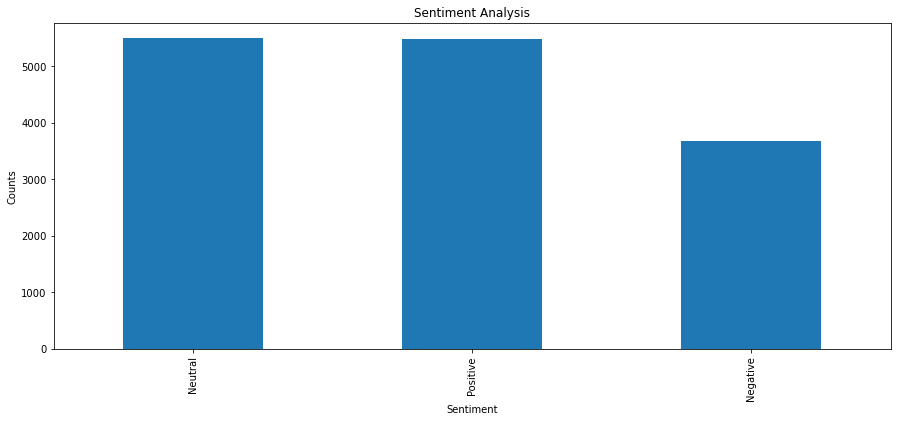

In [352]:
# Show the value counts
copy_df['Sentiment'].value_counts()

#plot and visualize the counts
plt.subplots(figsize= (15, 6))
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
copy_df['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [363]:
# Define function to preprocess text
def preprocess_text(text):
    # Tokenize text into individual words
    tokens = word_tokenize(text.lower())
    # Remove stop words
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_removed = [token for token in tokens if token not in stopwords_list]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stopwords_removed]
    # Join tokens back into a single string
    # Join tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text


# apply the preprocessing function
copy_df['preprocessed_text'] = copy_df['cleaned_text'].apply(lambda x: preprocess_text(x))
copy_df['preprocessed_text']

0                                                     said
1         plus youve added commercial experience ... tacky
2         didnt today ... must mean need take another trip
3        really aggressive blast obnoxious `` entertain...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving 20 minute late flight warning communic...
14637           please bring american airline blackberry10
14638    money change flight dont answer phone suggesti...
14639    8 ppl need 2 know many seat next flight plz pu...
Name: preprocessed_text, Length: 14640, dtype: object